## Notebook for testing and developing Unconditional Diffusion models


### Installing Dependencies

In [1]:
# Uncomment the following line to install the required packages
# %pip install -q diffusers
# %pip install python-dotenv
# %pip install accelerate
# %pip install torchmetrics
# %pip install torch-fidelity

### Config

In [19]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 12
    eval_batch_size = 50  # how many images to sample during evaluation
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    num_train_timesteps = 1000
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'unconditional_kneeOA'  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

### Load the dataset
Kaggle dataset available at https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity was used for the dataloader.  
The DATASET_HOME environment variable was set to the path of the dataset.  
The dataset was downloaded and unzipped in the DATASET_HOME directory.  

Dataset Structure:

DATASET_HOME/  
├── train/  
│   ├── 0/  
│   │   ├── image1L.png  
│   │   ├── image1R.png  
│   │   ├── image2L.png  
│   │   └── ...  
│   ├── 1/  
│   │   ├── image1L.png  
│   │   ├── image1R.png  
│   │   ├── image2L.png  
│   │   └── ...  
│   └── ...  
├── val/  
└── test/  






Training samples: 5778
Validation samples: 826
Test samples: 1656
Input shape: torch.Size([12, 1, 128, 128])
Labels: tensor([3, 0, 1, 2, 0, 3, 2, 0, 1, 0, 2, 3])


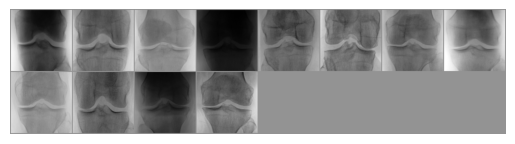

In [20]:
import os
from PIL import Image
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from torchvision import transforms

# Load environment variables
load_dotenv()
dataset_path = os.getenv('DATASET_HOME')

class KneeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Iterate through severity folders (0-4)
        for severity in range(5):
            severity_path = os.path.join(self.root_dir, str(severity))
            if not os.path.exists(severity_path):
                continue
                
            # Get all images in the severity folder
            for img_name in os.listdir(severity_path):
                if img_name.endswith(('.png')):
                    self.image_paths.append(os.path.join(severity_path, img_name))
                    self.labels.append(severity)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# Create datasets for train, validation and test
train_dataset = KneeDataset(dataset_path, split='train', transform=preprocess)
val_dataset = KneeDataset(dataset_path, split='val', transform=preprocess)
test_dataset = KneeDataset(dataset_path, split='test', transform=preprocess)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.eval_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize a batch
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
plt.axis('off')
plt.show()


### Define the model

In [4]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 1 for grayscale images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [5]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

### Define the noise scheduler


In [5]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps)

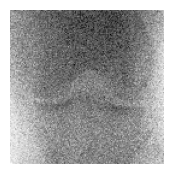

In [6]:
import torch
from PIL import Image

sample_image = train_dataset[0][0].unsqueeze(0) # type: ignore
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps) # type: ignore

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(noisy_image.squeeze().cpu().numpy(), cmap="Greys")
plt.axis('off')
plt.show()


### Set up Training Loop

In [7]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [9]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [10]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [11]:
from accelerate import Accelerator

from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
    accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, (images, labels) in enumerate(train_dataloader):
            clean_images = images
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

In [12]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=2)

Launching training on 2 GPUs.


/home/khizar/anaconda3/envs/mlflow/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/khizar/anaconda3/envs/mlflow/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/khizar/anaconda3/envs/mlflow/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Grad

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Lets Evaluate the model

#### Load the saved model

In [4]:
from diffusers import DDPMPipeline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Load the saved pipeline from the output directory
pipeline = DDPMPipeline.from_pretrained(config.output_dir)
pipeline.to("cuda")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "unconditional_kneeOA",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

#### Generate sample images

  0%|          | 0/1000 [00:00<?, ?it/s]

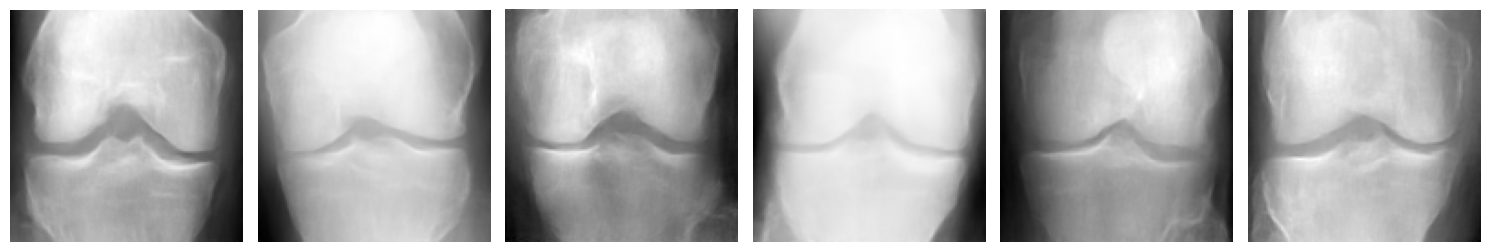

In [9]:
# Generate sample images
images = pipeline(
    batch_size=6,
    num_inference_steps=config.num_train_timesteps, 
    output_type="numpy"
).images

# Plot the generated images
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, image in enumerate(images):
    ax = axes[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Calculate Metrics (FID and Inception Score)

In [26]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torch
from tqdm.auto import tqdm
import numpy as np
import os
from PIL import Image

def generate_and_save_images(pipeline, num_generate, output_dir):
    """Generate images and save them to disk"""
    os.makedirs(output_dir, exist_ok=True)
    
    print("Generating and saving images...")
    with torch.no_grad():
        for i in tqdm(range(num_generate // config.eval_batch_size)):
            images = pipeline(
                batch_size=num_generate,
                num_inference_steps=config.num_train_timesteps, 
                output_type="numpy"
            ).images
            
            # Save each image in the batch
            for j, img in enumerate(images):
                # print(img.shape, img.min(), img.max())
                img = (img * 255).astype(np.uint8)
                # print(img.shape, img.min(), img.max())
                img = Image.fromarray(img.squeeze(), mode='L')
                img.save(os.path.join(output_dir, f'generated_{i*config.eval_batch_size + j}.png'))

def load_generated_images(image_dir, num_images):
    """Load generated images from disk"""
    images = []
    print("Loading generated images...")
    for i in tqdm(range(num_images)):
        img_path = os.path.join(image_dir, f'generated_{i}.png')
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img = np.array(img)[None, ...]  # Add channel dimension
            img = torch.from_numpy(img).float()
            # Convert to RGB by repeating channels
            img = img.repeat(3, 1, 1)
            # Scale to [0, 255] range
            img = img.to(torch.uint8)
            images.append(img)
    return torch.stack(images)

def calculate_metrics(generated_dir, real_dataloader, num_generate=100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Initialize metrics
    fid = FrechetInceptionDistance(feature=2048).to(device)
    inception_score = InceptionScore(feature=2048).to(device)
    
    # Load generated images
    generated_images = load_generated_images(generated_dir, num_generate)
    
    # Process real images
    print("Processing real images...")
    real_images = []
    with torch.no_grad():
        for (images, labels) in tqdm(real_dataloader):
            # Convert to RGB by repeating channels
            images = images.repeat((1, 3, 1, 1))
            # Scale to [0, 255] range
            # print(images.shape, images.min(), images.max())
            images = ((images + 1) * 127.5).clamp(0, 255).to(torch.uint8)
            # print(images.shape, images.min(), images.max())
            real_images.append(images)
            if len(torch.cat(real_images)) >= num_generate:
                break
    
    real_images = torch.cat(real_images)[:num_generate]
    
    # Calculate FID
    print("Calculating FID...")
    fid.update(real_images.to(device), real=True)
    fid.update(generated_images.to(device), real=False)
    fid_score = float(fid.compute())
    
    # Calculate Inception Score
    print("Calculating Inception Score...")
    inception_score.update(generated_images.to(device))
    is_mean, is_std = inception_score.compute()
    
    return {
        "fid": fid_score,
        "inception_score_mean": float(is_mean),
        "inception_score_std": float(is_std)
    }


In [22]:
# Generate and save images
generated_dir = "unconditional_generated_images"
generate_and_save_images(pipeline, num_generate=50, output_dir=generated_dir)

Generating and saving images...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
# Calculate metrics using the saved images
metrics = calculate_metrics(generated_dir, train_dataloader)
print(f"\nMetrics:")
print(f"FID Score: {metrics['fid']:.2f}")
print(f"Inception Score: {metrics['inception_score_mean']:.2f} ± {metrics['inception_score_std']:.2f}")


Loading generated images...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing real images...


  0%|          | 0/482 [00:00<?, ?it/s]

Calculating FID...
Calculating Inception Score...

Metrics:
FID Score: 85.41
Inception Score: 1.03 ± 0.00


In [8]:
pipeline.config

FrozenDict([('unet', ('diffusers', 'UNet2DModel')),
            ('scheduler', ('diffusers', 'DDPMScheduler')),
            ('_name_or_path', 'unconditional_kneeOA'),
            ('_class_name', 'DDPMPipeline'),
            ('_diffusers_version', '0.32.2')])